In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-30 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

In [5]:
cbr_germany = covid19.CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-25,154606,109800,5667,2240,3000,207
2020-04-26,155499,112300,5736,893,2500,69
2020-04-27,156234,114500,5842,735,2200,106
2020-04-28,157552,117400,6054,1318,2900,212
2020-04-29,159026,120400,6256,1474,3000,202


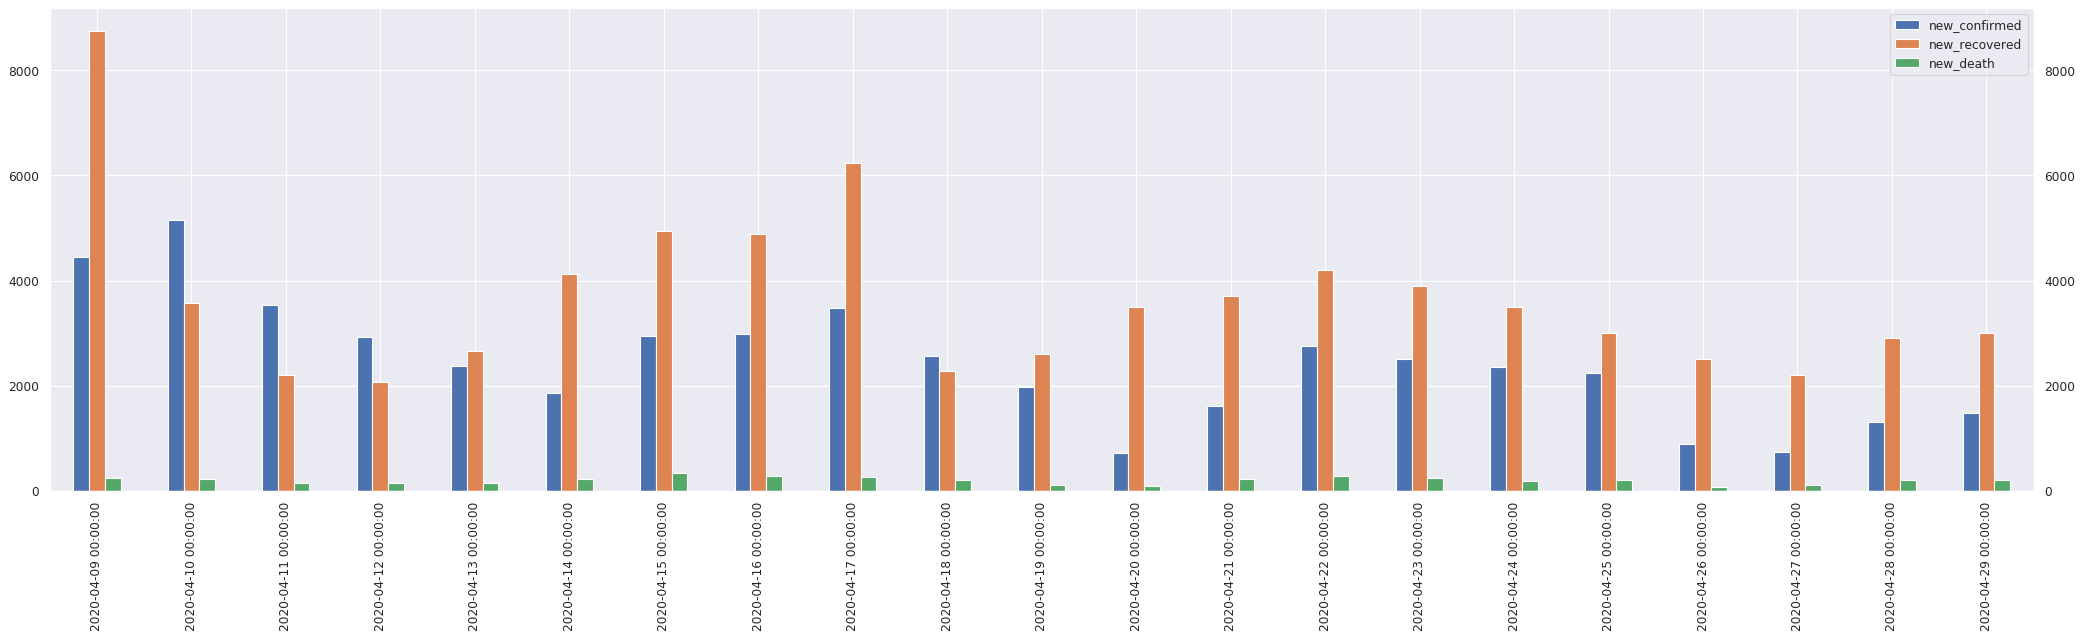

In [6]:
cbr_germany.plot_daily_stats()

sigmoid+asymmetric: seor: 801.3982087507345, max asymptotic: 170114.21728954147; growth-rate: 0.008, date:2020-05-27 00:00:00, projected value: 87.86326340305725


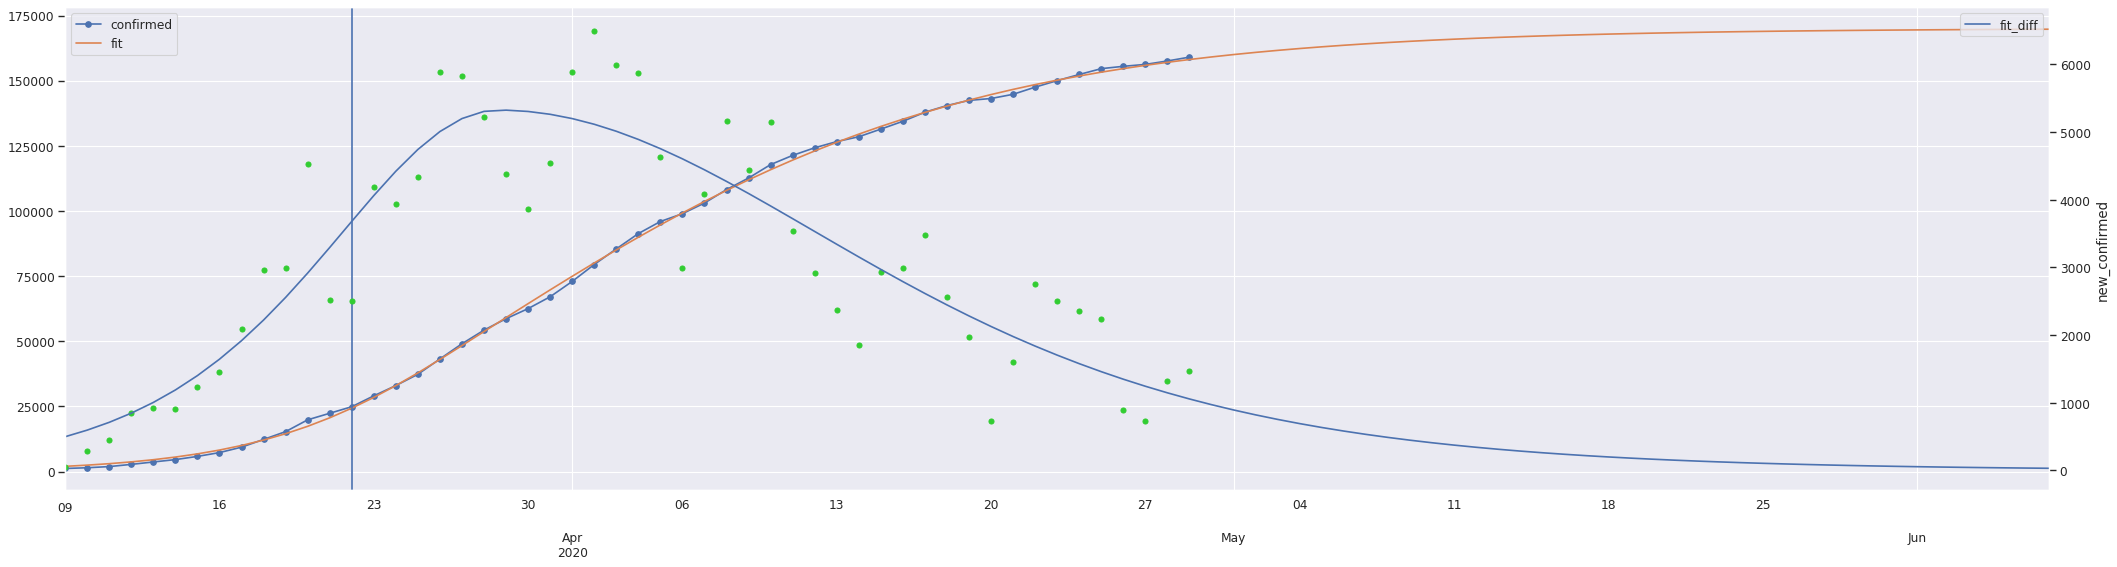

In [7]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [8]:
llfns = [covid19.LeadLagByShiftAndScale1, covid19.LeadLagByShiftAndScale2, covid19.LeadLagByShiftAndScale3]
# llfns = [covid19.LeadLagByShiftAndScale1]
lls = []

for llfn in llfns:
    ll = llfn(cbr_germany.df['confirmed'], cbr_germany.df['death'], first_date=pd.to_datetime('2020-03-09'))
    ll.fit()
    lls += [ll]

In [9]:
[ll.shift_and_scale_popt for ll in lls]

[array([ 0.04310979, 13.01778782]),
 array([ 0.04439493, 13.17146488]),
 array([ 0.04324621, 12.86766408])]

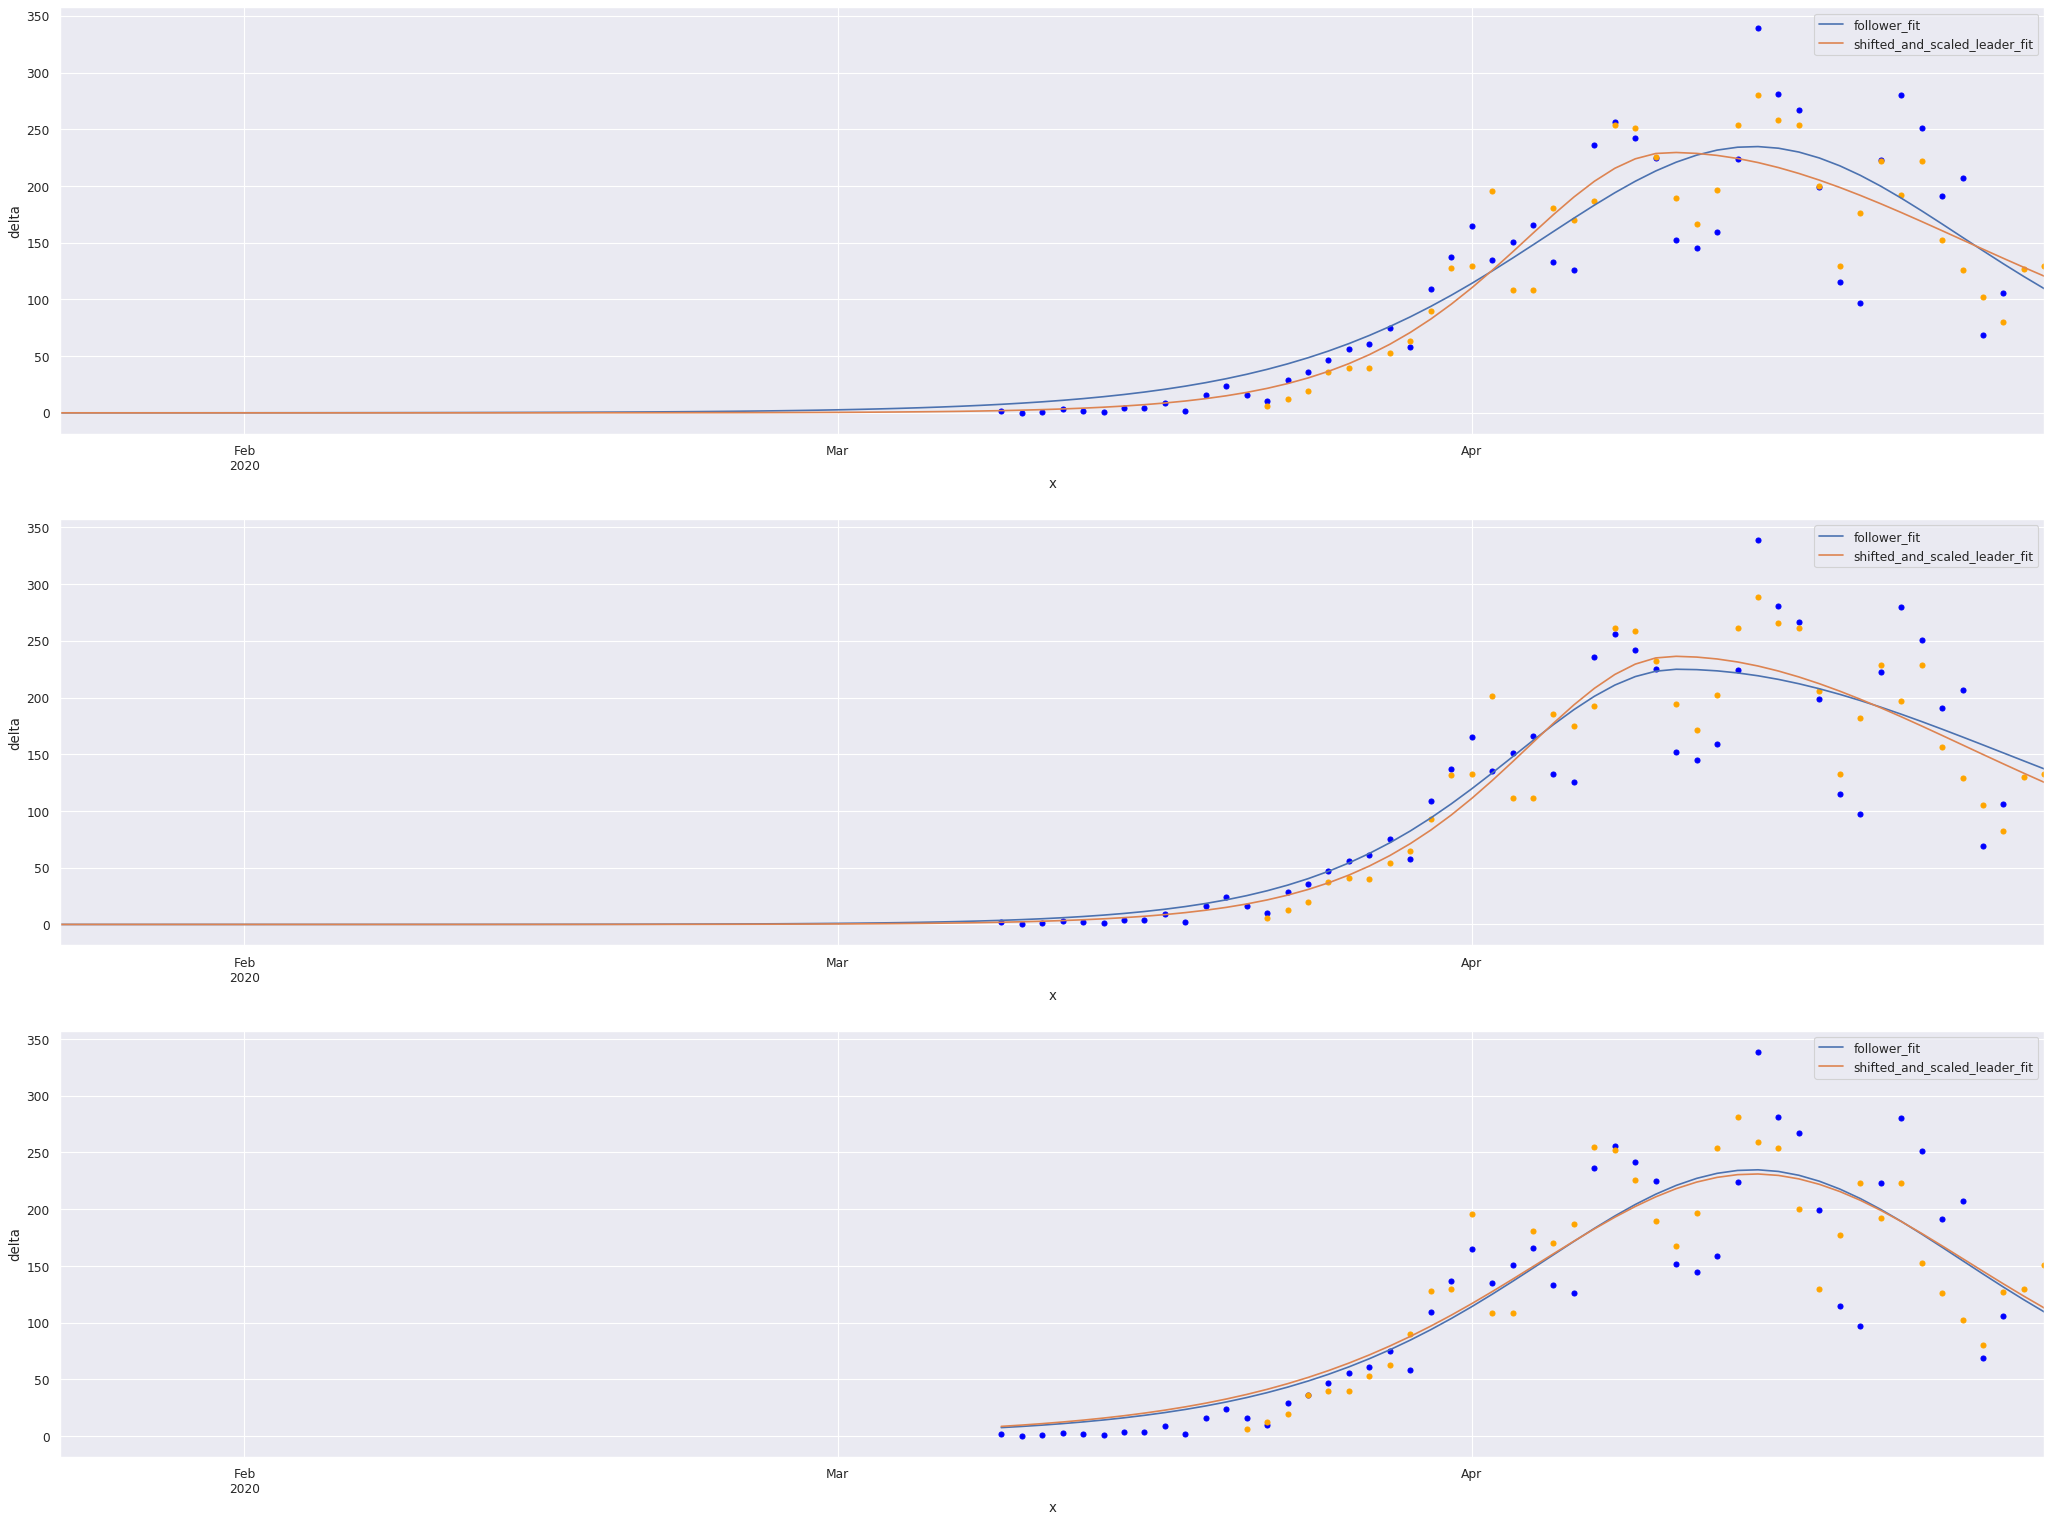

In [10]:
fig = plt.figure(figsize=(32,8*3), dpi=80, facecolor='w', edgecolor='k')
l = len(lls)
for i, ll in enumerate(lls):
    ax = plt.subplot(l,1, i+1)
    ll.plot(ax=ax)

In [11]:
lls[0].leader_fit_df0.head()

,x,total,delta
2020-03-09,47.0,1176,136.0
2020-03-10,48.0,1457,281.0
2020-03-11,49.0,1908,451.0
2020-03-12,50.0,2750,842.0
2020-03-13,51.0,3675,925.0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


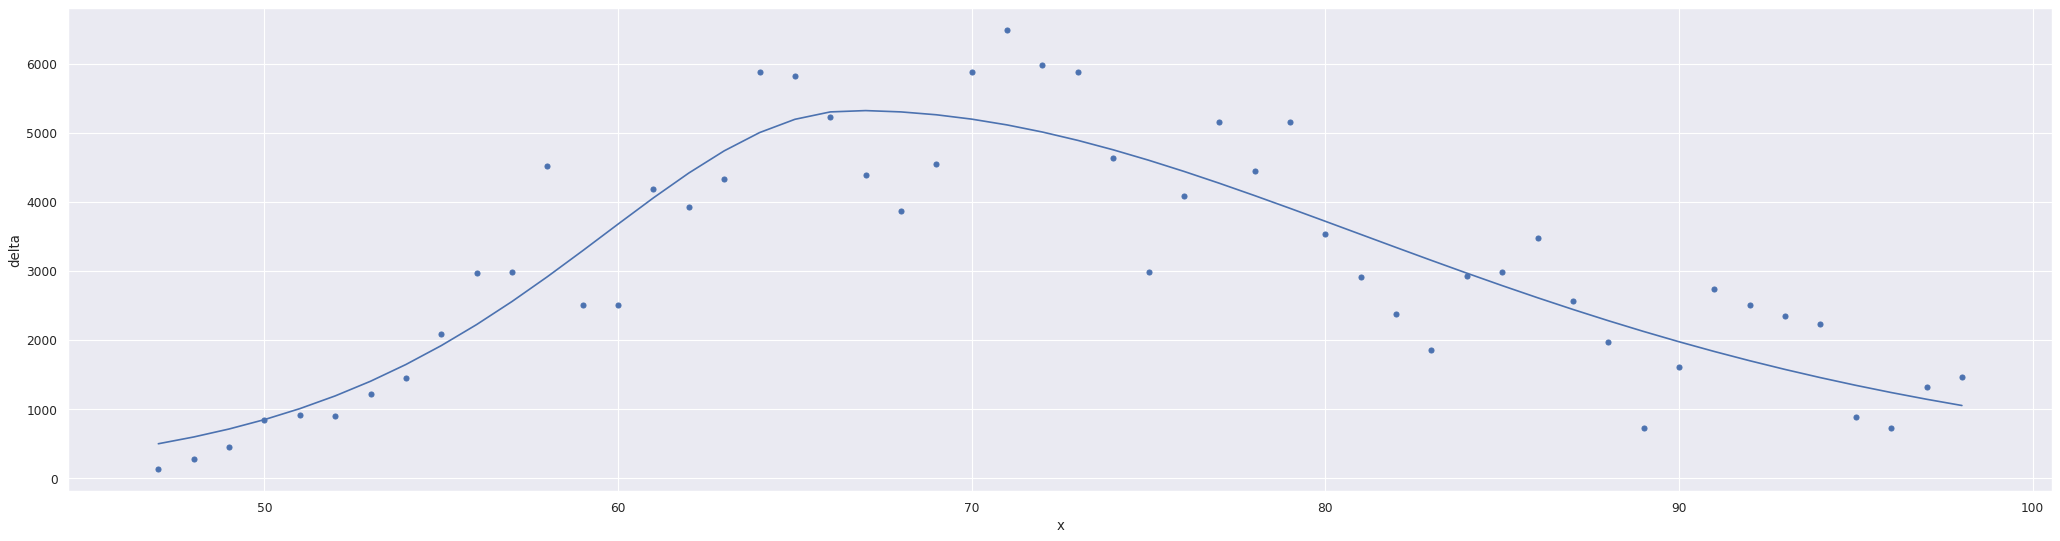

In [12]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
lls[0].leader_fit_df0.plot.scatter(ax=ax, x='x', y='delta')
ax.plot(lls[0].leader_fit_df0.x, lls[0].fn_leader_predict_dy(lls[0].leader_fit_df0.x))

In [13]:
lls[0].fc_leader.fit_

sigmoid+asymmetric: seor: 800.5205019707208, max asymptotic: 170114.2191273635

In [14]:
lls[0].follower_fit_df0.head()

,x,total,delta
2020-03-09,47.0,2,2.0
2020-03-10,48.0,2,0.0
2020-03-11,49.0,3,1.0
2020-03-12,50.0,6,3.0
2020-03-13,51.0,8,2.0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


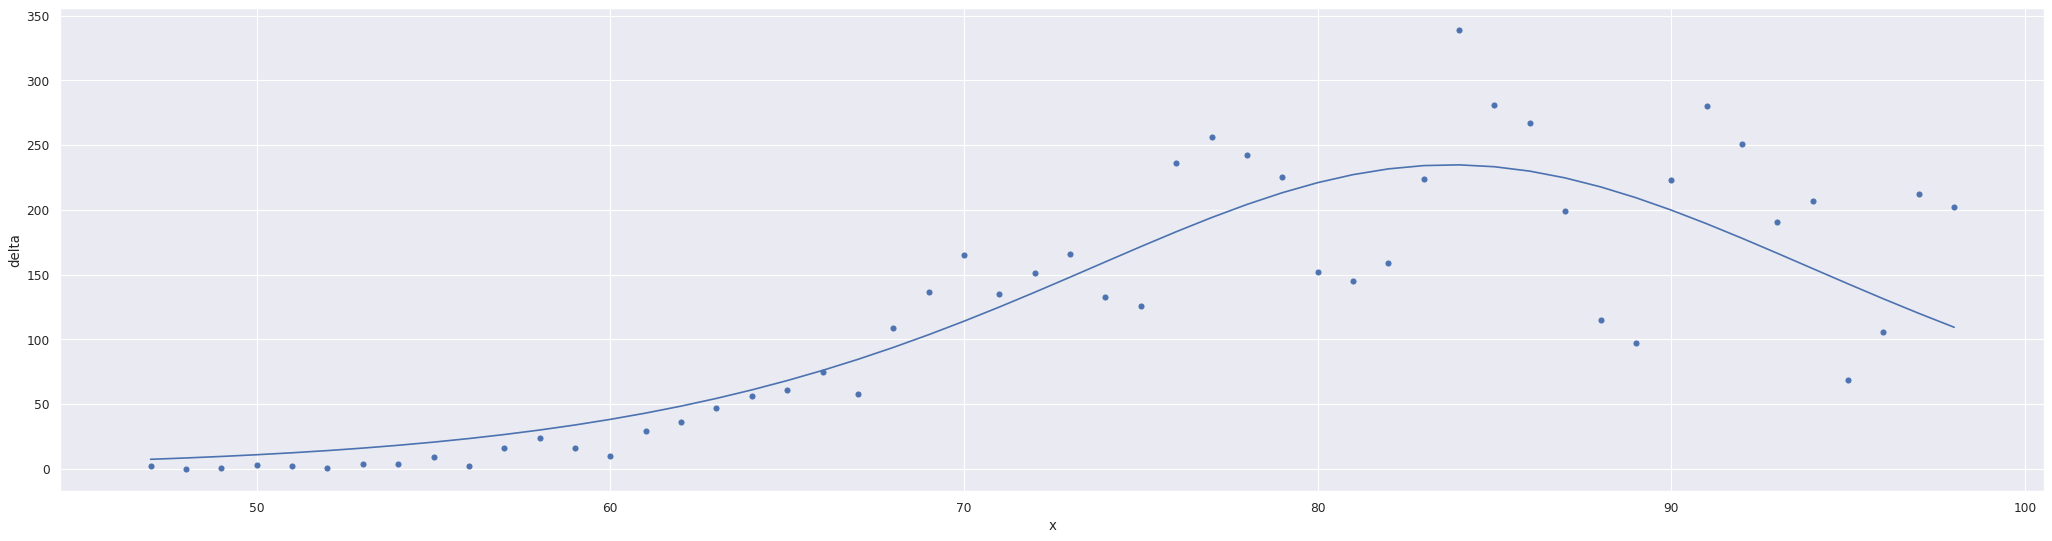

In [15]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
lls[0].follower_fit_df0.plot.scatter(ax=ax, x='x', y='delta')
ax.plot(lls[0].follower_fit_df0.x, lls[0].fn_follower_predict_dy(lls[0].follower_fit_df0.x))

In [16]:
lls[0].fc_follower.fit_

sigmoid: seor: 45.740435520476, max asymptotic: 6531.844201196712

In [17]:
lls[0].fit_df0 

,follower_fit,shifted_and_scaled_leader_fit
2020-01-23,0.018566,0.000342
2020-01-24,0.021162,0.000413
2020-01-25,0.024120,0.000498
2020-01-26,0.027491,0.000601
2020-01-27,0.031334,0.000726
...,...,...
2020-04-25,154.694264,152.425094
2020-04-26,142.919282,144.270305
2020-04-27,131.354264,136.185612
2020-04-28,120.148179,128.228516


In [18]:
lls[0].follower_fit_df[['delta']].head()

,delta
2020-03-09,2.0
2020-03-10,0.0
2020-03-11,1.0
2020-03-12,3.0
2020-03-13,2.0


In [19]:
lls[0].scaled_and_shifted_leader_df

,x,delta
2020-03-09,2020-03-22 00:25:36.867274,5.862931
2020-03-10,2020-03-23 00:25:36.867274,12.113850
2020-03-11,2020-03-24 00:25:36.867274,19.442514
2020-03-12,2020-03-25 00:25:36.867274,36.298441
2020-03-13,2020-03-26 00:25:36.867274,39.876553
...,...,...
2020-06-01,2020-06-14 00:25:36.867274,NaN
2020-06-02,2020-06-15 00:25:36.867274,NaN
2020-06-03,2020-06-16 00:25:36.867274,NaN
2020-06-04,2020-06-17 00:25:36.867274,NaN


In [20]:
lls[0].shift_and_scale_popt

array([ 0.04310979, 13.01778782])

CFR via Survival analysis: 4.54 (lower: 4.43, upper:4.65), CFR via shift and scale: 4.32 (time delay between infection and death: 12.91 days)


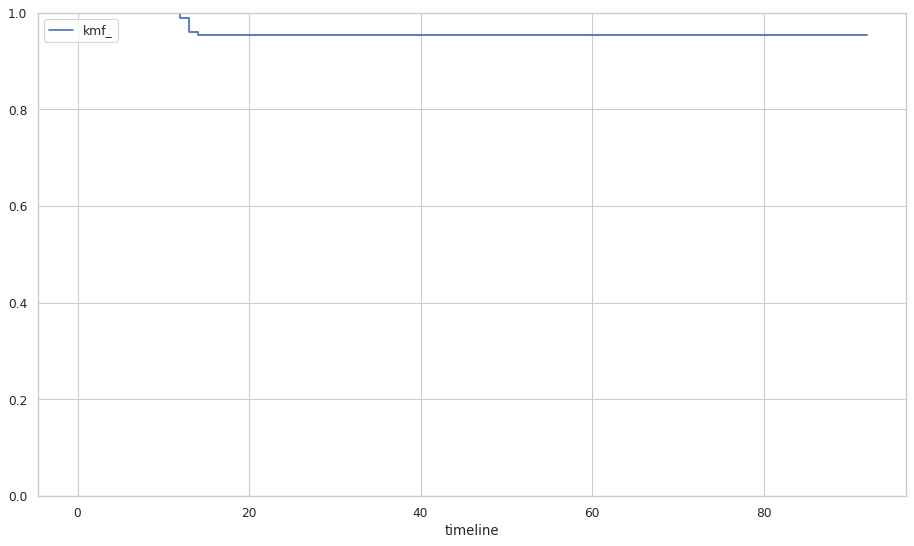

In [25]:
country_name, first_date, init_add = 'Germany', pd.to_datetime('2020-03-09'), 0.0
germany_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
germany_mortality_analysis.fit()
print(germany_mortality_analysis.print_death_rate())
germany_mortality_analysis.plot()